# Import libraries

In [1]:
import sys

sys.path.append('../')
from lib import twitter_utils_v2 as tu

# Driver code

Connect tweepy api client

In [2]:
client = tu.connect_full_client()

## Get user, timeline and followers

Handle of twitter account

In [3]:
handle='TRIResearch_'

Get 'User' data from twitter from handle (can also used twitter ID number if known)

In [4]:
user = tu.get_user(client,handle)
#user = get_user_id(client,user_id)

In [5]:
print('screen name: ' + user['name'])
print('description: ' + user['description'])
print('followers: ' + str(user['public_metrics']['followers_count']))
print('following: ' + str(user['public_metrics']['following_count']))
print('tweet count: '+str(user['public_metrics']['tweet_count']))
print('created: ' + str(user['created_at']))
print('verified: ' + str(user['verified']))

screen name: Trilateral Research
description: Trilateral Research is a leading multidisciplinary consulting and technology development company, we transform research and innovation into sustainable impact.
followers 3141
following 3894
tweet count13786
created: 2014-12-07T17:18:42.000Z
verified: False


Get user's timeline as a list

In [6]:
timeline = tu.get_timeline(client,user['id'])

Print some tweets

In [7]:
for tweet in timeline[0:3]:
    print(tweet['text'])
    print('\n')

The #healthcare sector is an established target for #ransomware attacks. In this article, we consider the implications and provide recommendations for healthcare and other #PublicSector organisations to ensure #compliance and protection of #PersonalData. https://t.co/a0rndcartO


What are #DarkPatterns, and how are they connected to #PersonalData and #PrivacyIssues? Read the @TRIResearch_'s blog to learn more about #DarkPatterns, their legal framework &amp; consequences, and how to protect your data. 🔗https://t.co/sriUSstKgn https://t.co/DlzQWJfPNF


We’re hiring! Do you have expertise in #EU or #UK #DataProtection legislation? @TRIResearch_ is looking for #AssociateDataProtectionAdvisor supporting our clients with data protection compliance. Apply here: https://t.co/PghXKxb42M




Get user's followers and following as a list of twitter ID numbers

In [8]:
followers = tu.get_follower_ids(client,user['id'])
following = tu.get_following_ids(client,user['id'])

In [9]:
len(followers)

3140

## Search API

Create query

 - Can use 'AND' and 'OR' operators between keywords
 - 'from:ACCOUNT' and 'to:ACCOUNT' used to find tweets from an account and tweets to an account
 - use '-'operator to negate query (i.e. '-covid' excludes tweets mentioning covid)
 - 'is:TYPE' to include particular types of tweets, e.g. reply, retweet etc
 
 More complete documentation found here: https://developer.twitter.com/en/docs/twitter-api/tweets/search/integrate/build-a-query

In [13]:
query = "vaccine OR mask -is:retweet"

In [14]:
tweets = tu.search_7_days(client,query,tweets_limit=500)

## Example account analysis

Import extra libraries

In [8]:
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
from dateutil import parser

Define functions

In [33]:
def twit_to_datetime(dtime):
    #new_datetime = datetime.datetime.strptime(dtime,'%a %b %d %H:%M:%S +0000 %Y')
    date = parser.parse(dtime)
    return date

def post_boosts(timeline):
    
    good_x = []
    good_y = []
    mid_x = []
    mid_y = []
    bad_x = []
    bad_y = []
    
    max_likes = 0
    max_rts = 0
    
    for tweet in timeline:
        likes = tweet['public_metrics']['like_count']
        if likes > max_likes:
            max_likes = likes
        rts = tweet['public_metrics']['retweet_count']
        if rts > max_rts:
            max_rts = rts
        if likes > 0:
            if rts/likes <= 0.9:
                good_x.append(likes)
                good_y.append(rts)
            elif rts/likes >= 1.2:
                bad_x.append(likes)
                bad_y.append(rts)
            else:
                mid_x.append(likes)
                mid_y.append(rts)
        else:
            mid_x.append(likes)
            mid_y.append(rts)

    fig, ax = plt.subplots(figsize=[8,8])

    fig.patch.set_facecolor('white')

    ax.plot(good_x, good_y, 'go',alpha=0.8,markersize=8)
    ax.plot(mid_x, mid_y, 'o',color='orange',alpha=0.8,markersize=8)
    ax.plot(bad_x, bad_y, 'ro',alpha=0.8,markersize=8)
    ax.plot([0,max([max_likes,max_rts])],[0,max([max_likes,max_rts])],'b-',alpha=0.9)

    ax.yaxis.grid(True)
    ax.xaxis.grid(True)
    ax.set_ylim([0,max_rts+5])
    ax.set_xlim([0,max_likes+5])
    ax.set(xlabel='Likes', ylabel='Rts',title=f'Post performance for {handle}')
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(15)

def posting_activity(timeline):
    x = []
    y = []

    for tweet in timeline:
        t = twit_to_datetime(tweet['created_at'])
        y.append(mdates.datestr2num(str(t.date())))
        x.append((datetime.timedelta(hours=t.hour, minutes=t.minute).seconds)/86400)

    fig, ax = plt.subplots(figsize=[12,8])

    fig.patch.set_facecolor('white')

    ax.plot([t*24 for t in x], y, 'mo',alpha=0.8,markersize=5)
    ax.set_xlim([0,24])
    ax.yaxis_date()
    ax.yaxis.grid(True)
    ax.set(title=f'Posting activity of {handle}',xlabel='Post hour (UTC)', ylabel='Post date')
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(15)

def follower_plot(full_followers):
    
    x=[]
    y=[]
    x1=[]
    y1=[]
    
    total = len(full_followers)
    
    for i, follower in enumerate(full_followers):
        y.append(mdates.datestr2num(follower['created_at']))
        x.append(total-i)
        if follower['public_metrics']['tweet_count'] < 100:
            y1.append(mdates.datestr2num(follower['created_at']))
            x1.append(total-i)
        

    #list.reverse(y)
    #list.reverse(y1)

    fig, ax = plt.subplots(figsize=[12,8])

    fig.patch.set_facecolor('white')

    ax.plot(x, y, 'bo', alpha=0.1)
    ax.plot(x1, y1, 'ro', alpha=0.1)
    ax.yaxis_date()

    ax.set(title = f'Followers of {handle}', xlabel='Follower number', ylabel='Signup date')
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(15)
     

Get data from twitter

In [3]:
handle='TRIResearch_'

In [11]:
user = tu.get_user(client,handle)

In [12]:
user_id = user['id']

In [ ]:
timeline = tu.get_timeline(client,user_id)

In [13]:
followers = tu.get_follower_ids(client,user_id)

Get full account details of followers (required for follower plot)

In [14]:
full_followers = tu.get_users_ids(client,followers)

0 batches processed
1 batches processed
2 batches processed
3 batches processed
4 batches processed
5 batches processed
10 batches processed
20 batches processed
30 batches processed


Print a graph of tweet activity from the account. This type of graph can help determine what times the account is active, and how regularly the account tweets. It may also be possible to infer whether the account is automated depending on the regularity of the activity

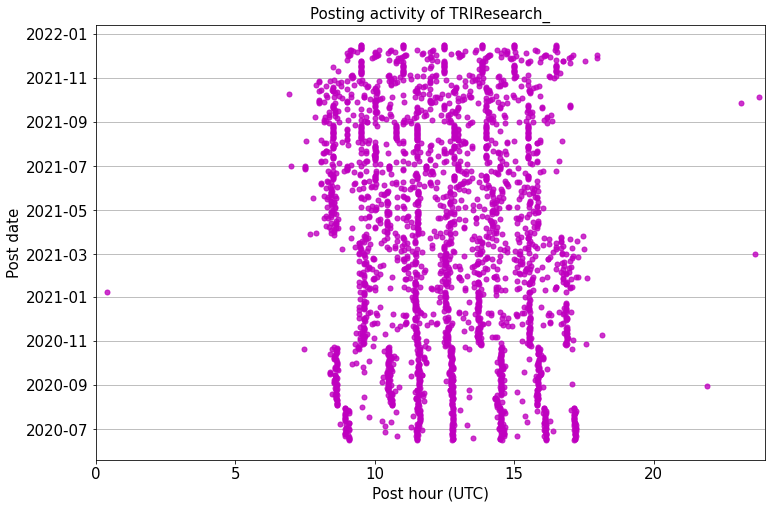

In [15]:
posting_activity(timeline)

Produce a plot of accounts following the main account vs the date when those accounts where created. In cases where an account has been followed by a large number of accounts consecutively all created at the same date, this can be seen as a thick horizontal cluster in the graph.

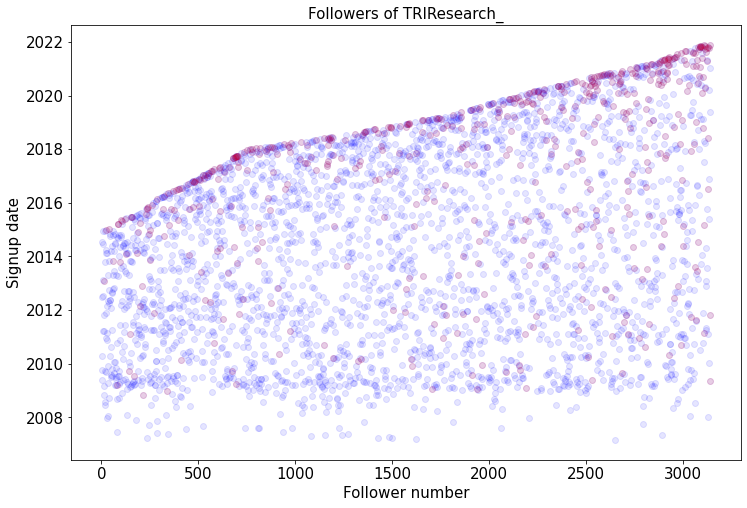

In [26]:
follower_plot(full_followers)

Plot the likes vs retweets for the account. Typically, the ratio of likes to tweets is > 1. Ratios consistently less than this (i.e. more retweets than likes) can be evidence that the account is part of an automated network of accounts that share content without an organic level of engagement.

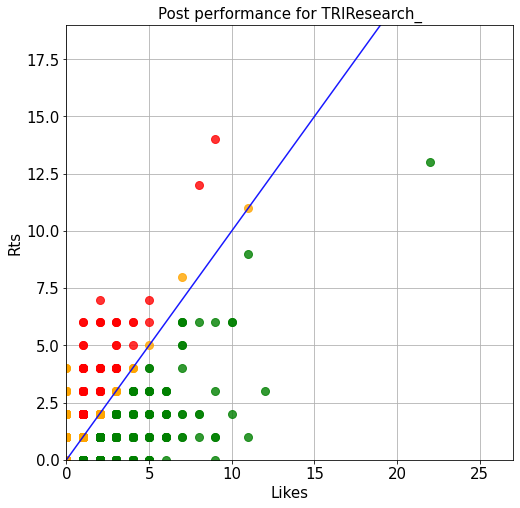

In [34]:
post_boosts(timeline)